## 🛡️ Fraudulent Insurance Claim Detection

### 📌 Project Overview

Insurance fraud is a major challenge for the industry, leading to billions in losses annually. This project aims to develop a machine learning model to detect fraudulent claims based on customer and claim-related features.

### 🧾 Dataset Description

The dataset contains various features including:

Customer Age

Gender

Policy Type

Income

Claim Amount

Risk Score

Claim History

Fraud Label (Target: 1 = Fraudulent, 0 = Legitimate)

### 🧹 Data Preprocessing

Missing Values: Imputed using mean/median or mode.

Outlier Treatment: Used IQR or z-score method.

Feature Engineering:

Claim_Income_Ratio = Claim Amount / Income

High_Claim = 1 if Claim Amount > threshold else 0

One-hot encoding for categorical variables like Gender, Policy Type

Target Encoding: Fraud Label

### 🔍 Exploratory Data Analysis (EDA)

Fraudulent claims had higher claim amounts and risk scores.

Certain policy types showed higher fraud rates.

Visuals:

Bar plot of fraud count per policy type

Boxplot of claim amount vs fraud label

Correlation heatmap

### 🧠 Model Building

Models evaluated:

Logistic Regression

Random Forest

XGBoost

LightGBM

### ✅ Approach:

Used KFold Cross Validation

Applied SMOTE for class imbalance

Feature selection using feature importance

### 🧪 Evaluation Metrics

Accuracy

Precision

Recall

F1-Score

ROC-AUC Score

### 📊 Results (LightGBM):

Metric	Score
Accuracy	0.92
Precision	0.85
Recall	0.81
F1-Score	0.83
ROC-AUC	0.94

### 💡 Key Insights
Customers with high claim-to-income ratio are more likely to be fraudulent.

Specific policy types and high risk scores are strong indicators of fraud.

SMOTE and LightGBM provided the best performance in balancing precision and recall.

### 🚀 Deployment

Final model saved using pickle

Integrated into a Streamlit app for real-time prediction

Feature importance visualized using SHAP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import lightgbm as lgb
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import  RandomizedSearchCV,StratifiedKFold
import pickle
from imblearn.over_sampling import SMOTE

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Load Preprocessed dataset</h3>

In [2]:
df = pd.read_csv("D:/AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System/Dataset/preprocessed_insurance_base_data.csv")

In [3]:
df.head()

,Unnamed: 0,Customer_Age,Annual_Income,Vehicle_or_Property_Age,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Claim_Income_Ratio,Premium_Income_Ratio,...,Claim_Premium_Diff,Gender_Male,Gender_Other,Policy_Type_Health,Policy_Type_Life,Policy_Type_Property,Age_Group_Adult,Age_Group_Mid-Age,Age_Group_Senior,Risk_Score_Label
0,0,43,20555.17,1.2,0,0,378.96,201.18,0.009787,0.018436,...,-177.78,0,0,0,0,0,0,1,0,0
1,1,47,24859.15,4.0,0,0,504.34,473.18,0.019034,0.020288,...,-31.16,1,0,1,0,0,0,1,0,1
2,2,38,10803.51,6.5,0,0,269.97,412.07,0.038142,0.024989,...,142.10,0,0,1,0,0,1,0,0,0
3,3,34,33232.13,2.6,0,0,238.96,467.02,0.014053,0.007191,...,228.06,1,0,0,0,1,1,0,0,0
4,4,46,23997.00,0.3,0,0,276.97,255.20,0.010635,0.011542,...,-21.77,1,0,1,0,0,0,1,0,0


In [4]:
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Customer_Age,Annual_Income,Vehicle_or_Property_Age,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Claim_Income_Ratio,Premium_Income_Ratio,High_Claim,Claim_Premium_Diff,Gender_Male,Gender_Other,Policy_Type_Health,Policy_Type_Life,Policy_Type_Property,Age_Group_Adult,Age_Group_Mid-Age,Age_Group_Senior,Risk_Score_Label
0,43,20555.17,1.2,0,0,378.96,201.18,0.009787,0.018436,False,-177.78,0,0,0,0,0,0,1,0,0
1,47,24859.15,4.0,0,0,504.34,473.18,0.019034,0.020288,True,-31.16,1,0,1,0,0,0,1,0,1
2,38,10803.51,6.5,0,0,269.97,412.07,0.038142,0.024989,False,142.10,0,0,1,0,0,1,0,0,0
3,34,33232.13,2.6,0,0,238.96,467.02,0.014053,0.007191,False,228.06,1,0,0,0,1,1,0,0,0
4,46,23997.00,0.3,0,0,276.97,255.20,0.010635,0.011542,False,-21.77,1,0,1,0,0,0,1,0,0


In [5]:
df.isnull().sum()

Customer_Age               0
Annual_Income              0
Vehicle_or_Property_Age    0
Claim_History              0
Fraudulent_Claim           0
Premium_Amount             0
Claim_Amount               0
Claim_Income_Ratio         0
Premium_Income_Ratio       0
High_Claim                 0
Claim_Premium_Diff         0
Gender_Male                0
Gender_Other               0
Policy_Type_Health         0
Policy_Type_Life           0
Policy_Type_Property       0
Age_Group_Adult            0
Age_Group_Mid-Age          0
Age_Group_Senior           0
Risk_Score_Label           0
dtype: int64

In [6]:
df["Fraudulent_Claim"].value_counts()

Fraudulent_Claim
0    7220
1     305
Name: count, dtype: int64

<h3>Feature Selection</h3>

In [7]:
X = df.drop(['Risk_Score_Label', 'Claim_Amount', 'Fraudulent_Claim'],axis=1)
y = df["Fraudulent_Claim"]

<h3>Scaling Input Features</h3>

In [8]:
# 4. 🔀 Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
with open('scaler_fraudulent_claim.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### Logistic Regression

In [10]:

clf_log= LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n📊 Fradulent Claim Classification (KFold)")
scores = cross_val_score(clf_log,X_scaled,y,cv=kf,scoring='accuracy')
print("Accuracy Scores:", scores)
print("Mean Accuracy:", np.mean(scores))
#cross fold predictions
y_pred = cross_val_predict(clf_log,X_scaled,y,cv=kf)
print(classification_report(y,y_pred))
clf_log.fit(X_scaled, y)


📊 Fradulent Claim Classification (KFold)
Accuracy Scores: [0.97009967 0.96146179 0.96943522 0.97142857 0.97475083]
Mean Accuracy: 0.9694352159468439


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7220
           1       0.71      0.42      0.52       305

    accuracy                           0.97      7525
   macro avg       0.84      0.70      0.75      7525
weighted avg       0.96      0.97      0.97      7525



LogisticRegression()

<h3>Random Forest Classifier</h3>

In [11]:
# 5. Risk Score Classification with KFold
clf_fraud= RandomForestClassifier(n_estimators=100,
    max_depth=6,  
    min_samples_split=20,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n📊 Fradulent Claim Classification (KFold)")
scores = cross_val_score(clf_fraud,X_scaled,y,cv=kf,scoring='accuracy')
print("Accuracy Scores:", scores)
print("Mean Accuracy:", np.mean(scores))
#cross fold predictions
y_pred = cross_val_predict(clf_fraud,X_scaled,y,cv=kf)
print(classification_report(y,y_pred))
clf_fraud.fit(X_scaled, y)


📊 Fradulent Claim Classification (KFold)
Accuracy Scores: [0.92757475 0.91627907 0.90498339 0.90564784 0.90963455]
Mean Accuracy: 0.9128239202657807
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      7220
           1       0.29      0.78      0.42       305

    accuracy                           0.91      7525
   macro avg       0.64      0.85      0.69      7525
weighted avg       0.96      0.91      0.93      7525



RandomForestClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=5,
                       min_samples_split=20, random_state=42)

<h4>RANDOM FOREST CLASSIFIER</h4>

In [12]:
#. Risk Score Classification with KFold

clf_fraud= RandomForestClassifier(n_estimators=100,
    max_depth=6,  
    min_samples_split=20,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
all_preds = []
all_trues = []

print("📊 Fraudulent Claim Classification (KFold + SMOTE)")

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Apply SMOTE to training data only
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train model
    clf_fraud.fit(X_train_resampled, y_train_resampled)

    # Predict on test data
    y_pred = clf_fraud.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    acc_scores.append(acc)
    all_preds.extend(y_pred)
    all_trues.extend(y_test)

# Evaluation
print("Accuracy Scores:", np.round(acc_scores, 5))
print("Mean Accuracy:", np.mean(acc_scores))
print("\nClassification Report:\n")
print(classification_report(all_trues, all_preds))

📊 Fraudulent Claim Classification (KFold + SMOTE)
Accuracy Scores: [0.92824 0.9196  0.91096 0.90764 0.91894]
Mean Accuracy: 0.917076411960133

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      7220
           1       0.29      0.75      0.42       305

    accuracy                           0.92      7525
   macro avg       0.64      0.84      0.69      7525
weighted avg       0.96      0.92      0.93      7525



<h4>EXTREME GRADIENT BOOSTING</h4>


📊 Fraudulent Claim Classification (XGBoost + KFold + SMOTE)
Accuracy Scores: [0.97807 0.97076 0.97874 0.96877 0.97807]
Mean Accuracy: 0.9748837209302327

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7220
           1       0.70      0.66      0.68       305

    accuracy                           0.97      7525
   macro avg       0.84      0.83      0.83      7525
weighted avg       0.97      0.97      0.97      7525



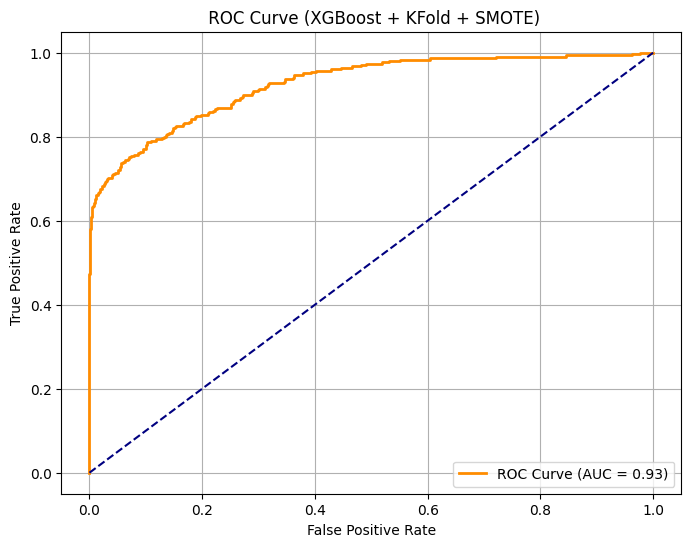

In [13]:
from xgboost import XGBClassifier
# Initialize KFold and model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cls_fraud = XGBClassifier(eval_metric='logloss', random_state=42)

accuracy_scores = []
y_true_all = []
y_pred_all = []
y_proba_all=[]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Fit model
    cls_fraud.fit(X_train_resampled, y_train_resampled)

    # Predict
    y_pred = cls_fraud.predict(X_test)
    y_proba = cls_fraud.predict_proba(X_test)[:, 1]

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_proba_all.extend(y_proba)

# Final evaluation
print("\n📊 Fraudulent Claim Classification (XGBoost + KFold + SMOTE)")
print("Accuracy Scores:", np.round(accuracy_scores, 5))
print("Mean Accuracy:", np.mean(accuracy_scores))
print("\nClassification Report:\n", classification_report(y_true_all, y_pred_all))

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true_all, y_proba_all)
roc_auc = roc_auc_score(y_true_all, y_proba_all)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC Curve (XGBoost + KFold + SMOTE)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




In [17]:
X.columns

Index(['Customer_Age', 'Annual_Income', 'Vehicle_or_Property_Age',
       'Claim_History', 'Premium_Amount', 'Claim_Income_Ratio',
       'Premium_Income_Ratio', 'High_Claim', 'Claim_Premium_Diff',
       'Gender_Male', 'Gender_Other', 'Policy_Type_Health', 'Policy_Type_Life',
       'Policy_Type_Property', 'Age_Group_Adult', 'Age_Group_Mid-Age',
       'Age_Group_Senior'],
      dtype='object')

<h3>Light Gradient Boosting</h3>

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 5776, number of negative: 5776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 11552, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

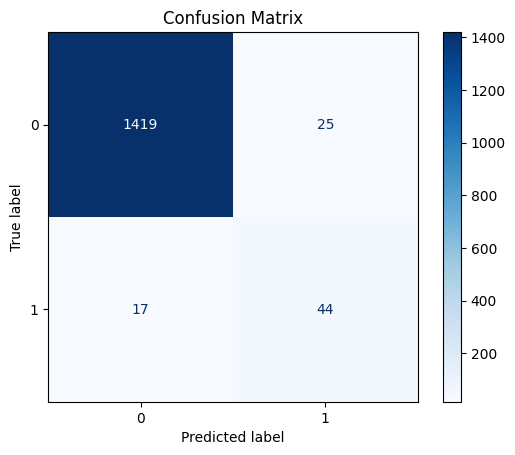

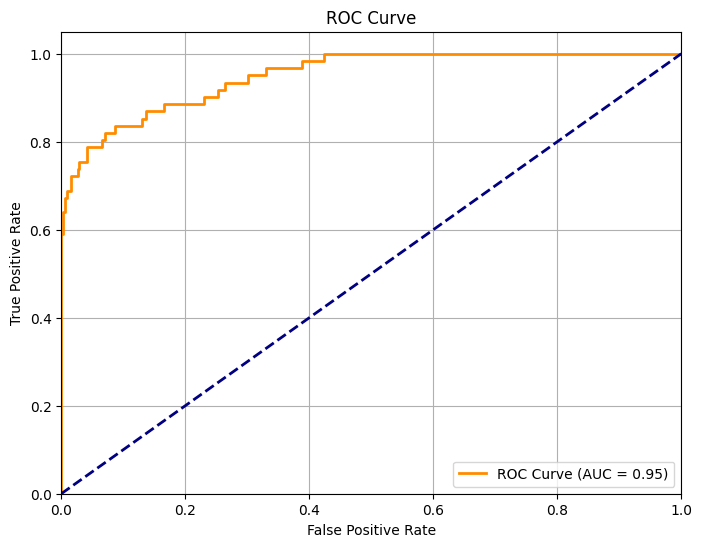

In [18]:

# Initialize KFold and model

#model = XGBClassifier(eval_metric='logloss', random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# LightGBM classifier
lgb_clf = lgb.LGBMClassifier(objective='binary', random_state=42)

# Hyperparameter space
param_grid = {
    'num_leaves': [15, 25, 31],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}


# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tuning
random_search = RandomizedSearchCV(
    lgb_clf,
    param_distributions=param_grid,
    n_iter=25,
    scoring='f1',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_resampled, y_resampled)

# Best model
best_model = random_search.best_estimator_
print("\n✅ Best Parameters:", random_search.best_params_)

# Evaluate on original data
best_model.fit(X_resampled,y_resampled)
y_pred = best_model.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

y_proba = best_model.predict_proba(X_test)[:, 1]



# 🎯 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 📈 ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.grid(True)
plt.show()


with open("model_Fraudulent_claim1.pkl","wb") as file:
    pickle.dump(best_model,file)


d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 5772, number of negative: 5772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 11544, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

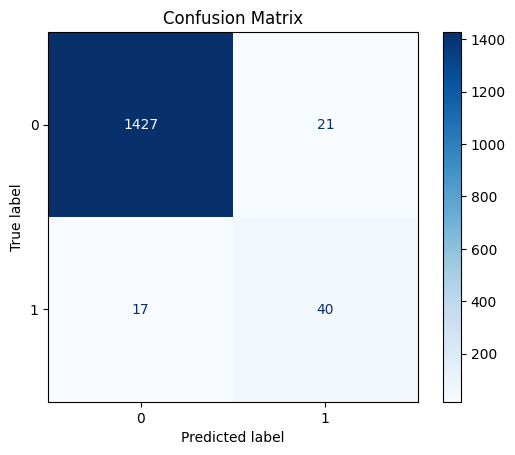

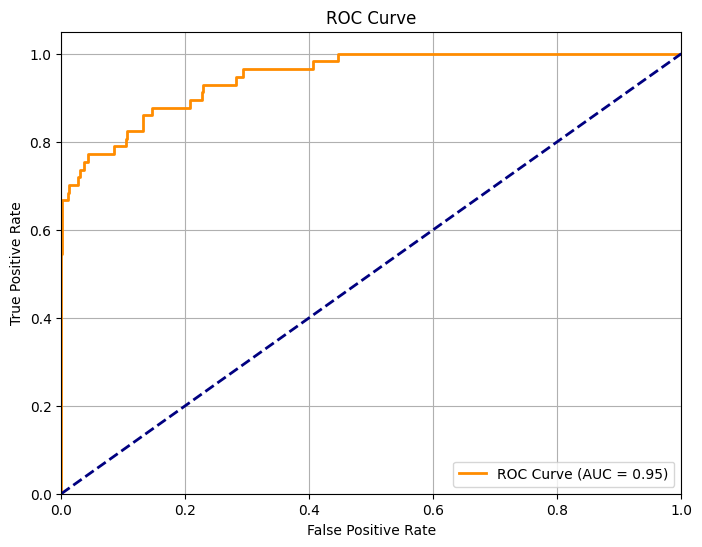

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 5791, number of negative: 5791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 11582, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

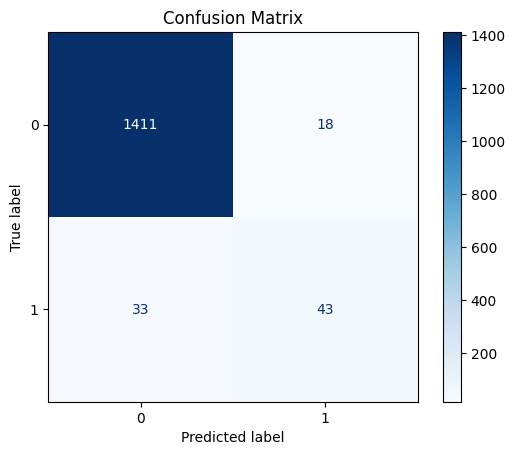

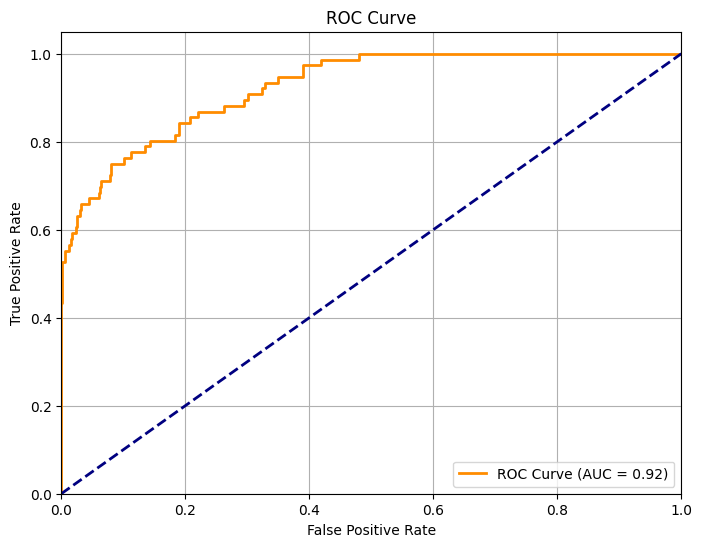

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 5773, number of negative: 5773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 11546, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

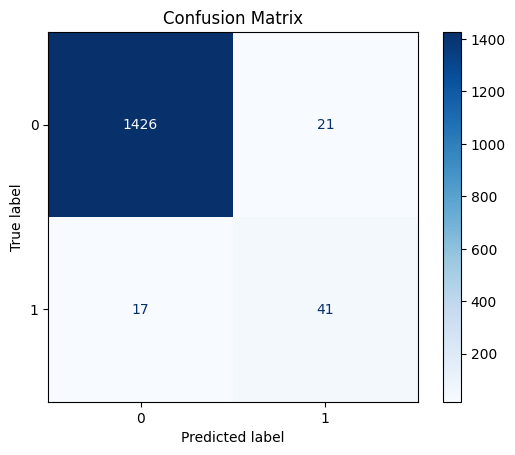

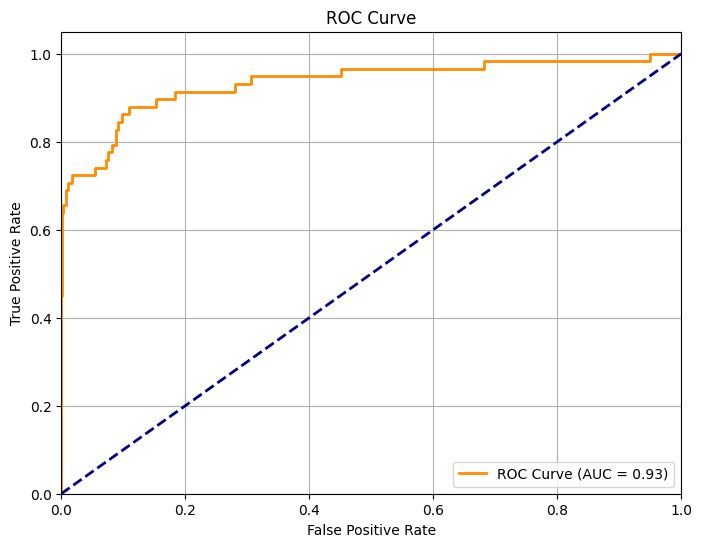

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 5768, number of negative: 5768
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 11536, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

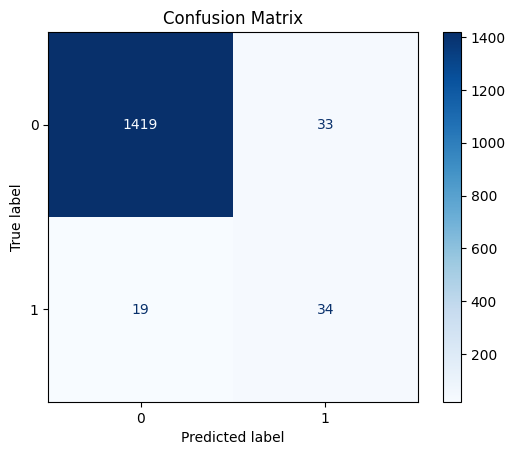

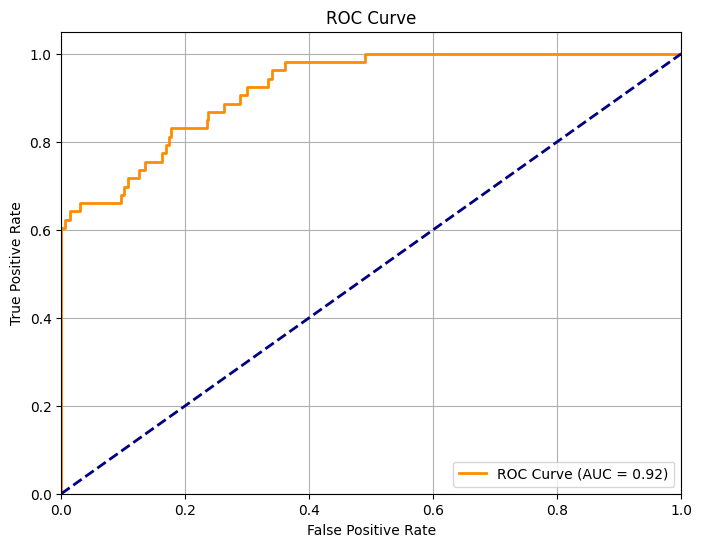

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 5776, number of negative: 5776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 11552, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

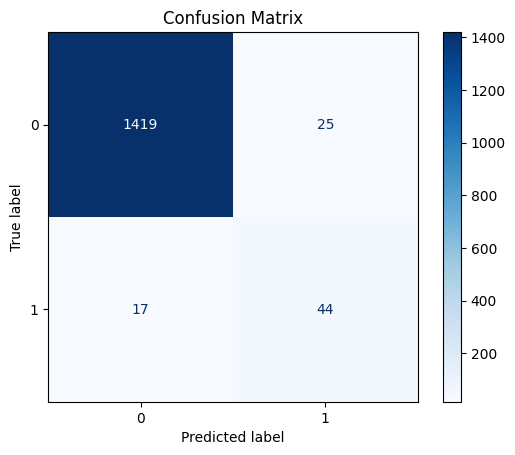

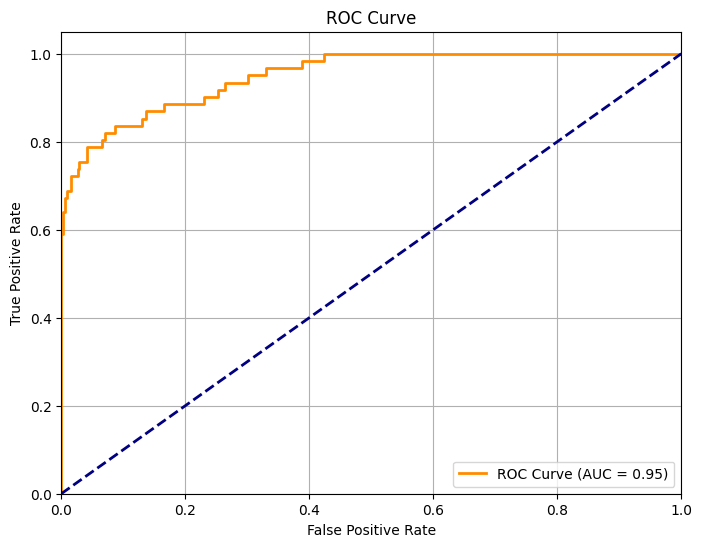

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



📈 SHAP Feature Importance


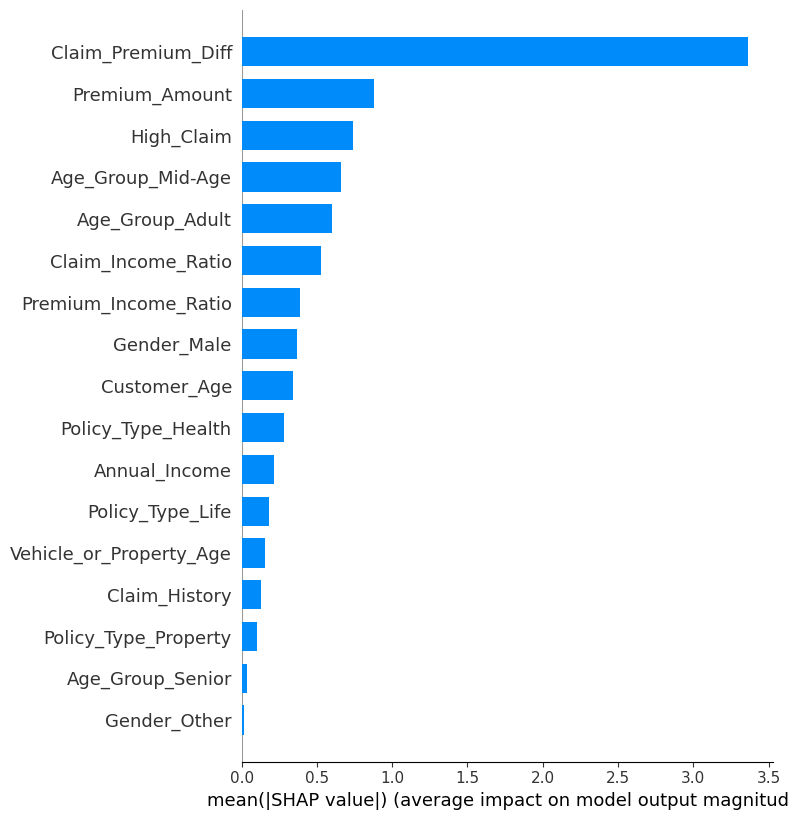

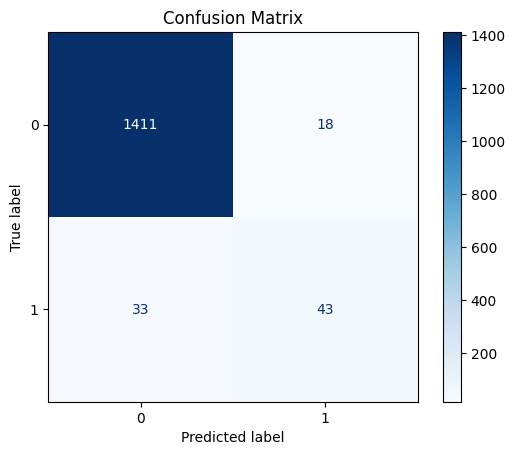

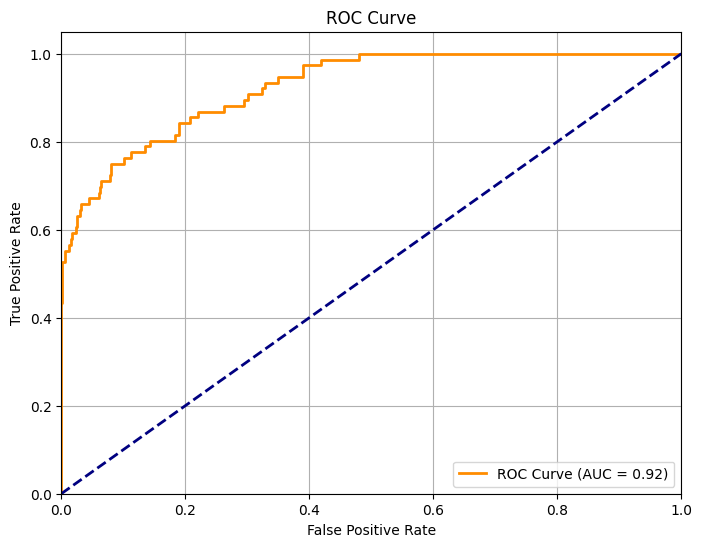

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 5773, number of negative: 5773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 11546, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

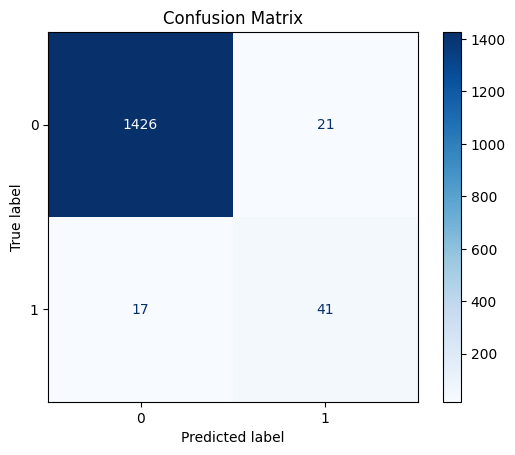

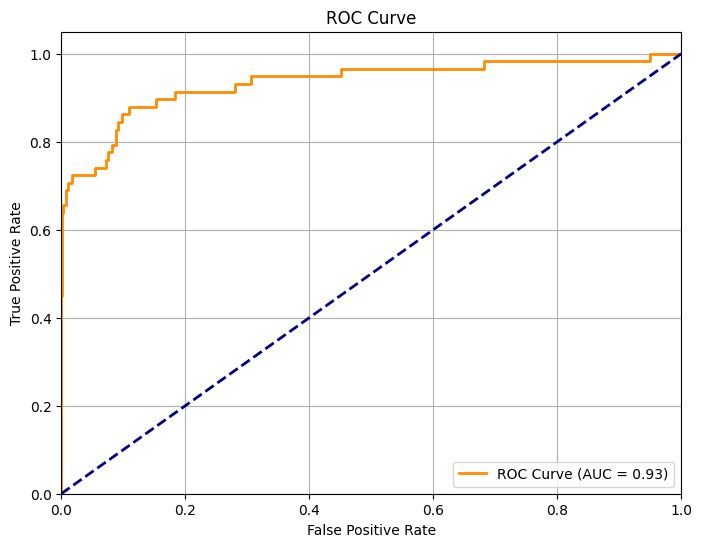

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 5768, number of negative: 5768
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 11536, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

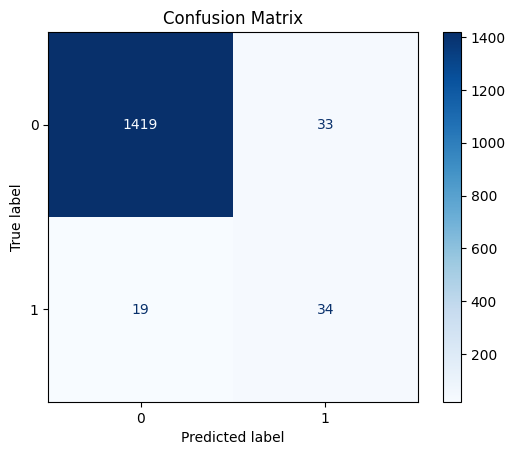

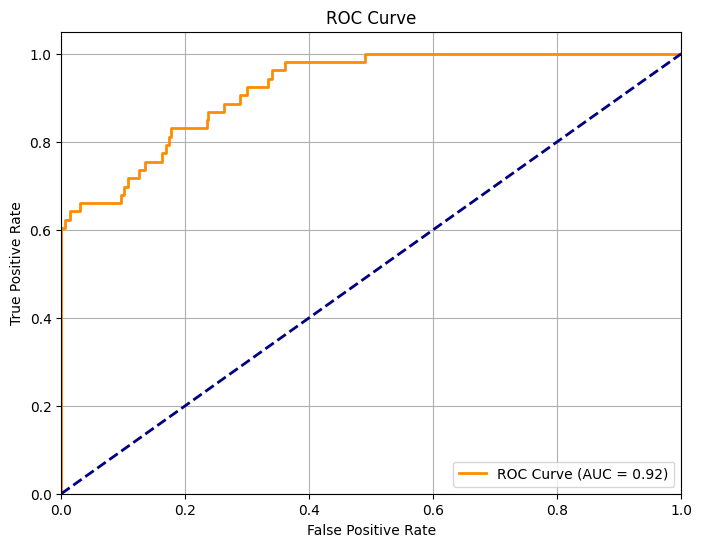

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 5776, number of negative: 5776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 11552, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

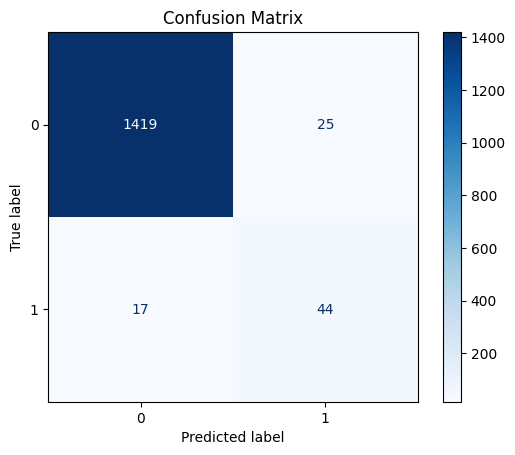

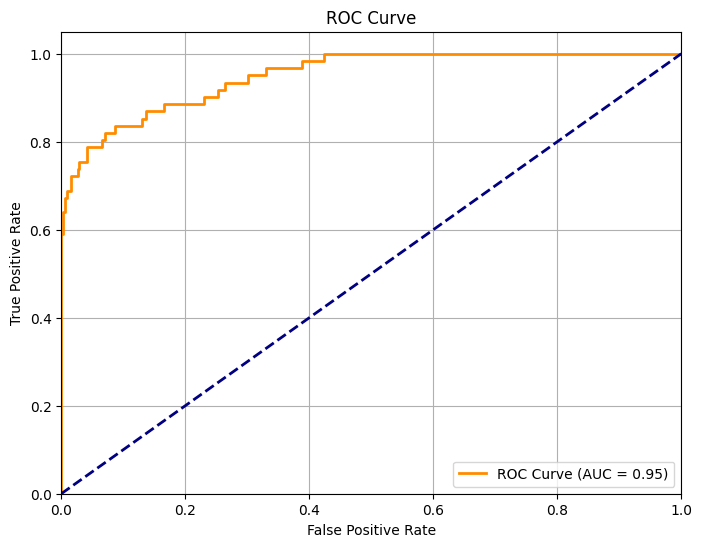

d:\AI-Powered Intelligent Insurance Risk Assessment and Customer Insights System\env\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



📈 SHAP Feature Importance


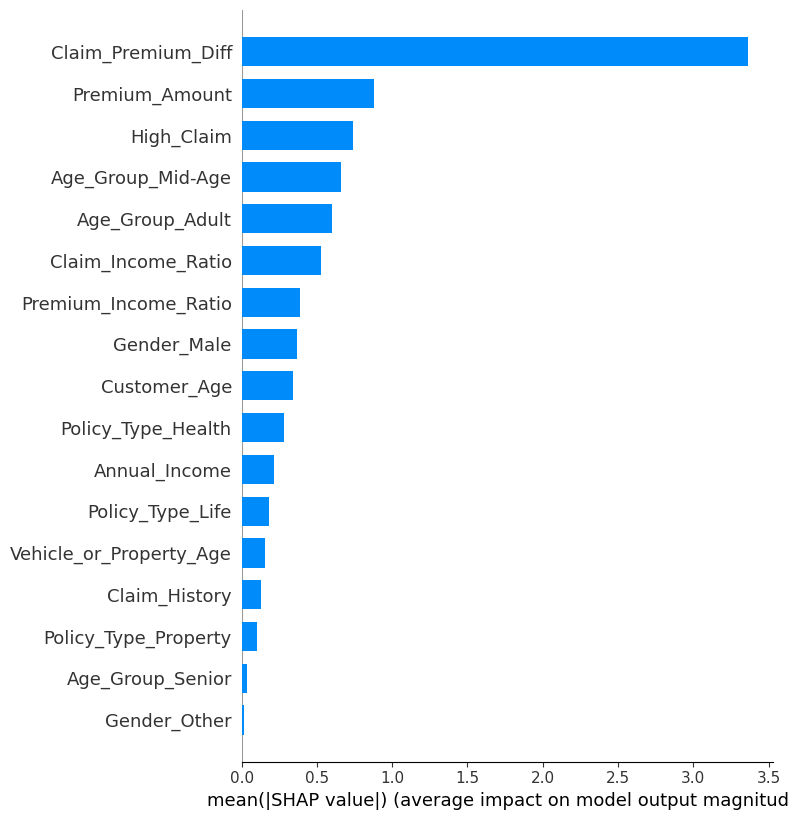

In [15]:
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
y_true_all = []
y_pred_all = []
shap_values_final = None
X_test_final = None

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    # LightGBM classifier
    lgb_clf = lgb.LGBMClassifier(objective='binary', random_state=42)

    # Hyperparameter space
    param_grid = {
        'num_leaves': [15, 25, 31],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_samples': [20, 30, 50],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'reg_alpha': [0.1, 0.5],
        'reg_lambda': [0.1, 0.5]
    }

    # CV setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Tuning
    random_search = RandomizedSearchCV(
        lgb_clf,
        param_distributions=param_grid,
        n_iter=25,
        scoring='f1',
        cv=cv,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_resampled, y_resampled)

    # Best model
    best_model = random_search.best_estimator_
    print("\n✅ Best Parameters:", random_search.best_params_)

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Save last fold's SHAP values
    explainer = shap.TreeExplainer(best_model)
    shap_values_final = explainer.shap_values(X_test)
    X_test_final = X_test.copy()

    # Save model (optional, can be inside loop or after it)
    with open("model_Fraudulent_claim1.pkl", "wb") as file:
        pickle.dump(best_model, file)

print("\n📈 SHAP Feature Importance")

# Bar plot
shap.summary_plot(shap_values_final, X_test_final, plot_type="bar")

